# Hierarchical A* Exploration
based on The [Generalized A* Architecture by Felzenszwalb and McAllester](https://cs.brown.edu/people/pfelzens/papers/astar.pdf)

In [1]:
from collections import namedtuple
from dataclasses import dataclass
from enum import Enum
import heapq as heap
from copy import copy
from typing import Optional, List
import numpy as np
from IPython.display import HTML


from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph.graph import ShortestPathSolution, Graph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams
from large_gcs.graph.factored_collision_free_graph import FactoredCollisionFreeGraph

In [2]:
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger("drake").setLevel(logging.ERROR)

Want to start with a simple example, trichal4

INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


100%|██████████| 2/2 [00:00<00:00, 18001.30it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11983.73it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.95it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 19245.20it/s]


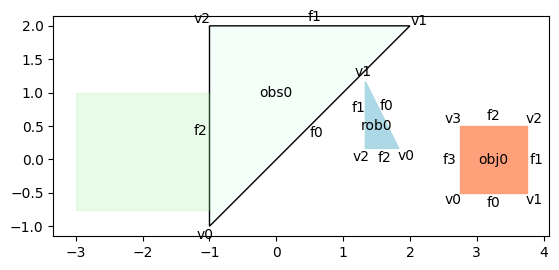

In [3]:
graph_name = "cg_trichal4"
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name(graph_name)
cg_inc = IncrementalContactGraph.load_from_file(graph_file, should_add_gcs=True)
cg_inc.target_name
cg_inc.plot()

In [4]:
from large_gcs.algorithms.gcs_hastar import GcsHAstar
from large_gcs.abstraction_models.contact_two import ContactTwo

abs_model = ContactTwo().generate(cg_inc)
reexplore_levels = ["NONE", "FULL"]
gcs_hastar = GcsHAstar(abs_model, reexplore_levels)



INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 7/7 [00:00<00:00, 11468.80it/s]
INFO:large_gcs.graph.graph:Adding 7 vertices to graph...
100%|██████████| 7/7 [00:00<00:00, 10345.36it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 21/21 [00:00<00:00, 8722.56it/s]
INFO:large_gcs.graph.contact_graph:22 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 22/22 [00:00<00:00, 12309.86it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 22/22 [00:00<00:00, 6380.05it/s]
INFO:large_gcs.graph.graph:Adding 22 edges to graph...
100%|██████████| 22/22 [00:00<00:00, 8141.41it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Created factored collision free graph for obj0: GraphParams(dim_bounds=(2, 4), n_vertices=7, n_edges=22, source=[array([3.25, 0.  ])], target='regions', workspace=array([[-5,  5],
       

In [ ]:
gcs_hastar.run()